# Import necessary libraries
SAFEP_parse.py contains all the functions and library calls necessary to run the notebook
# Required libraries:
- numpy
- pandas
- matplotlib
- alchemlyb (pip install git+https://github.com/alchemistry/alchemlyb)
- natsort (for sorting file names)
- glob (for unix-like file paths)



# IMPORTANT: Make sure the temperature (set below) matches the temperature you used to run the simulations.

In [1]:
from AFEP_parse import *
plt.rcParams['figure.dpi'] = 150

In [2]:
def batchProcess(paths, RT):
    u_nks = {}
    affixes = {}

    #Read all
    for path in paths:
        print(f"Reading {path}")
        key = path.split('/')[-2]
        fepoutFiles = glob(path+'/'+pattern)
        u_nks[key], affix = readAndProcess(fepoutFiles, temperature, decorrelate, detectEQ)


    ls = {}
    l_mids = {}
    fs = {}
    dfs = {}
    ddfs = {}
    errorses = {}
    dG_fs = {}
    dG_bs = {}

    #do BAR fitting
    for key in u_nks:
        u_nk = u_nks[key]
        u_nk = u_nk.sort_index(level=1)
        bar = BAR()
        bar.fit(u_nk)
        ls[key], l_mids[key], fs[key], dfs[key], ddfs[key], errorses[key] = get_BAR(bar)
        
        expl, expmid, dG_fs[key], dG_bs[key] = get_EXP(u_nk)

    #Collect into dataframes - could be more pythonic but it works
    cumulative = pd.DataFrame()
    for key in ls:
        #cumulative[(key, 'l')] = ls[key]
        cumulative[(key, 'f')] = fs[key]
        cumulative[(key, 'errors')] = errorses[key]
    cumulative.columns = pd.MultiIndex.from_tuples(cumulative.columns)

    perWindow = pd.DataFrame()
    for key in ls:
        #perWindow[(key, 'l_mid')] = l_mids[key]
        perWindow[(key, 'df')] = dfs[key]
        perWindow[(key, 'ddf')] = ddfs[key]
        perWindow[(key, 'dG_f')] = dG_fs[key]
        perWindow[(key, 'dG_b')] = dG_bs[key]
    perWindow.columns = pd.MultiIndex.from_tuples(perWindow.columns)
    perWindow.index = l_mids[key]
    
    return u_nks, cumulative, perWindow, affix

In [3]:
root = '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/FEP/'
pattern = 'PO*fepout'
prefix='POEG'
paths = glob(root+prefix+'*/')
header = 'Ternary 211'

In [4]:
temperature = 303.15
RT = 0.00198720650096 * temperature # ca. 0.59kcal/mol
decorrelate = True #Flag for decorrelation of samples
detectEQ = False #Flag for automated equilibrium detection
DiscrepancyFitting = 'LS' #ML = fit PDF of discrepancies with a normal distribution maximum likelihood estimator. LS = fit CDF of discrepancies with a normal distribution least-squares estimator

In [5]:
u_nks, cumulative, perWindow, affix = batchProcess(paths, RT)

Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/FEP/POEG_1/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875
/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:135: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  return df.sort_index(0).reset_index('time').duplicated('time').any()
/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:133: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  return df.sort_index(0).reset_index('time

Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/FEP/POEG_18/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/FEP/POEG_104/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/FEP/POEG_47/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/FEP/POEG_71/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/FEP/POEG_old/


         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875


Decorrelating samples. Flag='True'


In [6]:
perWindow[('mean', 'df')] = np.mean(perWindow.loc[:, (slice(None), 'df')], axis=1)
perWindow[('mean', 'ddf')] = np.mean(perWindow.loc[:, (slice(None), 'ddf')], axis=1)
perWindow[('mean', 'dG_f')] = np.mean(perWindow.loc[:, (slice(None), 'dG_f')], axis=1)
perWindow[('mean', 'dG_b')] = np.mean(perWindow.loc[:, (slice(None), 'dG_b')], axis=1)

In [7]:
l0s = list(set(perWindow.columns.get_level_values(0)))
for key in l0s:
    perWindow[(key, 'diff')] = perWindow[(key, 'dG_f')]+perWindow[(key, 'dG_b')]

# Plot the change in free energy based on MBAR estimates

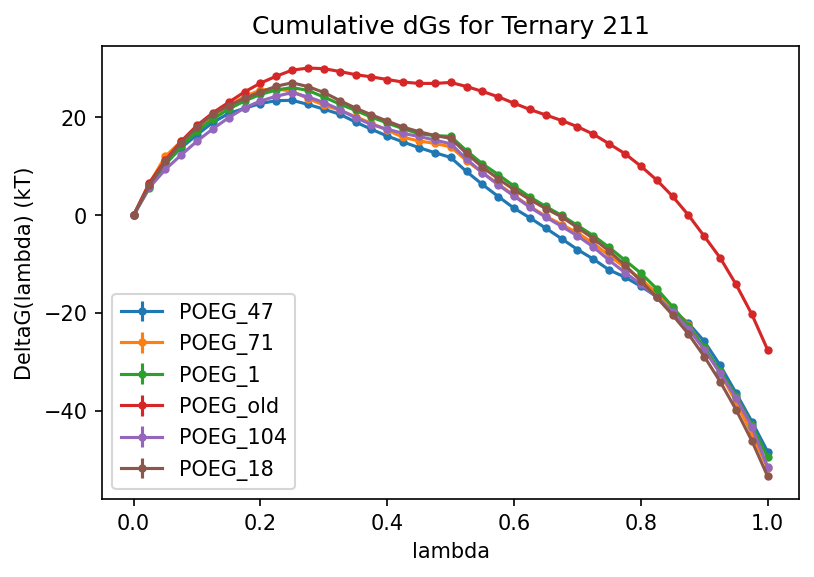

In [8]:
# Cumulative change in kT
keys = set(cumulative.columns.get_level_values(0))
for key in keys:
    plt.errorbar(cumulative.index, cumulative[(key, 'f')], yerr=cumulative[(key, 'errors')], marker='.', label=key)
    plt.xlabel('lambda')
    plt.ylabel('DeltaG(lambda) (kT)')
    plt.legend()
    plt.title(f'Cumulative dGs for {header}')
plt.savefig(f"{root}/{prefix}_cumulative_{affix}.png", dpi=600)

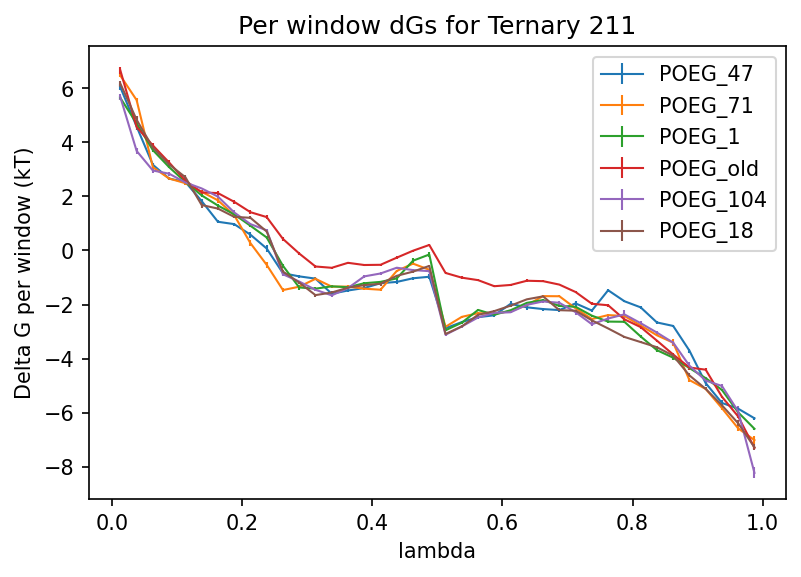

In [9]:
# Per-window change in kT

keys = set(cumulative.columns.get_level_values(0))
for key in keys:
    plt.errorbar(perWindow.index, perWindow[(key, 'df')], yerr=perWindow[(key, 'ddf')], label=key, linewidth=1)
    plt.xlabel('lambda')
    plt.ylabel('Delta G per window (kT)')
    plt.legend()
    plt.title(f'Per window dGs for {header}')
    #plt.title(f'Cumulative dG with accumulated errors {affixes[0]}\n{changeAndError}')
plt.savefig(f"{root}/{prefix}_perWindow_{affix}.png", dpi=600)

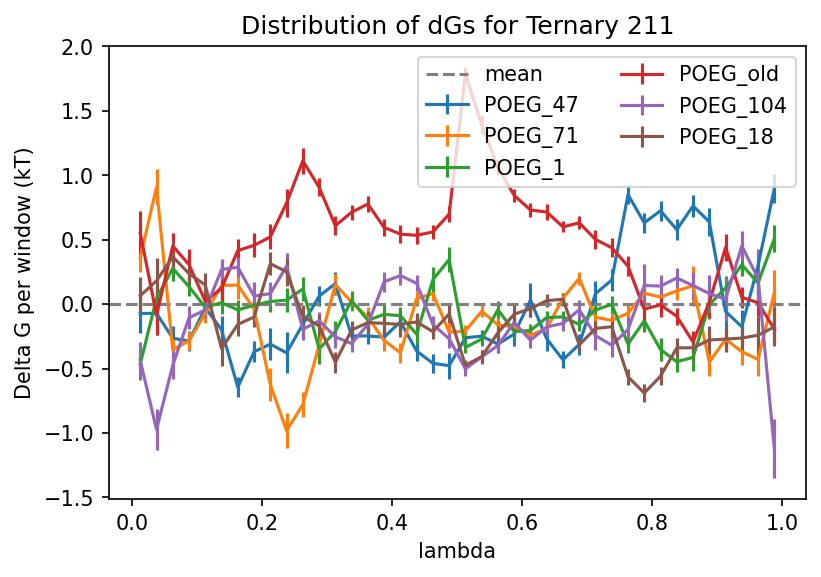

In [10]:
keys = list(set(cumulative.columns.get_level_values(0)))


for key in keys:
    plt.errorbar(perWindow.index, perWindow[(key, 'df')]-perWindow[('mean', 'df')], yerr=np.sqrt(perWindow[('mean', 'ddf')]**2 + perWindow[(key, 'ddf')]**2), label=key)
plt.xlabel('lambda')
plt.ylabel('Delta G per window (kT)')
plt.axhline(0, linestyle='--', color='grey', label='mean')
plt.legend(ncol=2)
plt.title(f'Distribution of dGs for {header}')
plt.savefig(f"{root}/{prefix}_perWindow_diff_{affix}.png", dpi=600)

# Use an exponential estimator to assess residual discrepancies and check for hysteresis

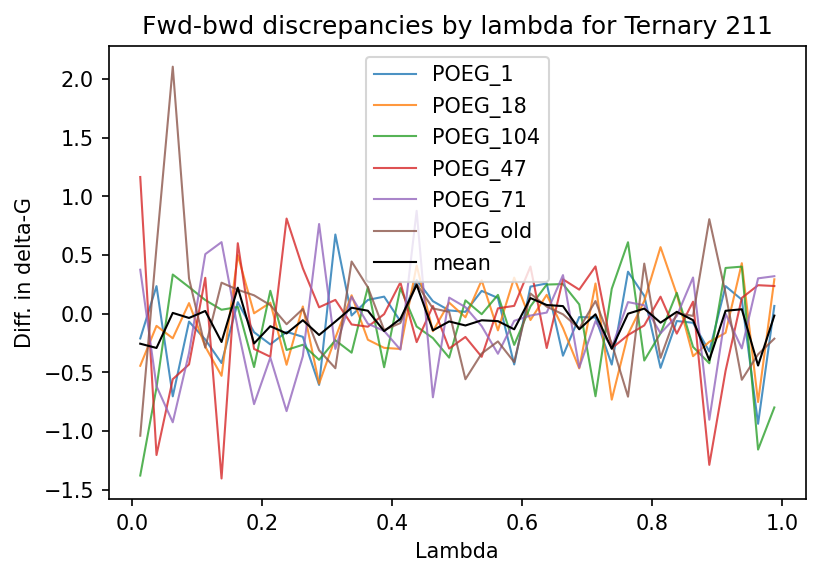

In [11]:
for key in u_nks:
    #plt.vlines(perWindow.index, np.zeros(len(perWindow)), perWindow[(key, 'dG_f')] + perWindow[(key, 'dG_b')], label=key, linewidth=2)
    plt.plot(perWindow.index, perWindow[(key, 'diff')], label=key, linewidth=1, alpha=0.8)

plt.plot(perWindow.index, perWindow[('mean', 'diff')], label='mean', linewidth=1, color='black')

plt.legend()
plt.title(f'Fwd-bwd discrepancies by lambda for {header}')
plt.xlabel('Lambda')
plt.ylabel('Diff. in delta-G')
plt.savefig(f'{root}/{prefix}_discrepancies_{affix}.png', dpi=600)

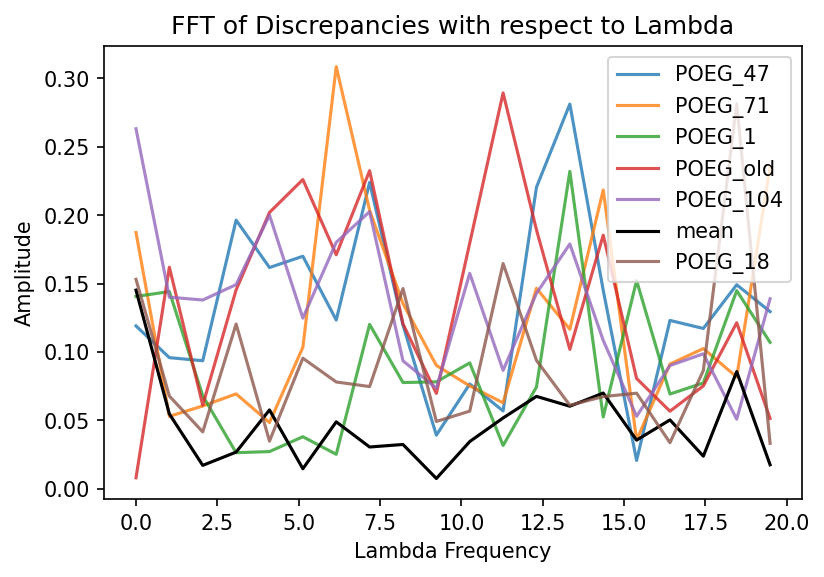

In [12]:
keys = list(set(perWindow.columns.get_level_values(0)))
for key in keys:
    myFFT = np.fft.fft(perWindow[(key, 'diff')])
    n_samples = len(perWindow)

    amplitudes = 2/n_samples * np.abs(myFFT)

    frequencies = np.fft.fftfreq(n_samples) * n_samples * 1/(perWindow.index[-1]-perWindow.index[0])
    
    if key == 'mean':
        plt.plot(frequencies[:len(frequencies)//2], amplitudes[:len(myFFT)//2], label=key, color='black')
    else:
        plt.plot(frequencies[:len(frequencies)//2], amplitudes[:len(myFFT)//2], label=key, alpha=0.8)

    plt.legend()
    plt.title(f'FFT of Discrepancies with respect to Lambda')
    plt.xlabel('Lambda Frequency')
    plt.ylabel('Amplitude')


# Estimate and plot the Probability Density Function (PDF) for the differences shown above.

In [13]:
from scipy.special import erfc
from scipy.optimize import curve_fit as scipyFit
from scipy.stats import skew
#Wrapper for fitting the normal CDF
def cumFn(x, m, s):
    r = norm.cdf(x, m, s)
    return r

def pdfFn(x,m,s):
    r = norm.pdf(x,m,s)
    return r

/home/ems363/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3579: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


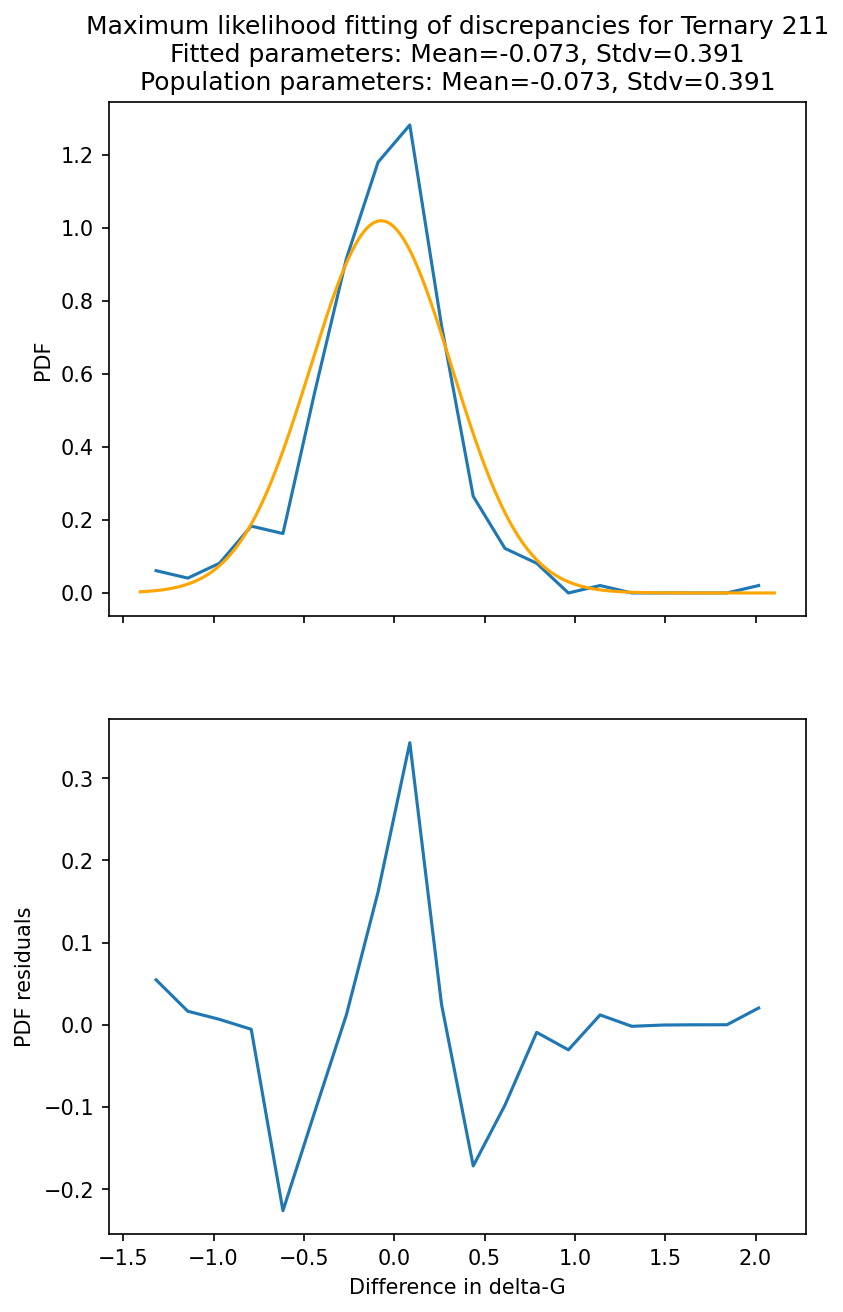

In [14]:
diff = perWindow.loc[:, (slice(None), 'diff')]
X = diff
Y = np.arange(len(X))/len(X)

#plot the data
fig, (pdfAx, pdfResid) = plt.subplots(2, 1, sharex=True)
plt.xlabel('Difference in delta-G')

#fit a normal distribution to the existing data
fitted = norm.fit(X) # fit a normal distribution to X
discrepancies = diff

#pdf
dx = 0.01

binNum = 20
pdfY, pdfX = np.histogram(discrepancies, bins=binNum, density=True)
pdfX = (pdfX[1:]+pdfX[:-1])/2

pdfXnorm  = np.arange(np.min(np.min(X)), np.max(np.max(X)), dx)
pdfYnorm = norm.pdf(pdfXnorm, fitted[0], fitted[1])

pdfYexpected = norm.pdf(pdfX, fitted[0], fitted[1])

pdfAx.plot(pdfX, pdfY,  label="Estimated Distribution")
pdfAx.set_ylabel("PDF")
pdfAx.plot(pdfXnorm, pdfYnorm, label="Fitted Normal Distribution", color="orange")

#pdf residuals
pdfResiduals = pdfY-pdfYexpected
pdfResid.plot(pdfX, pdfResiduals)
pdfResid.set_ylabel("PDF residuals") 

fig.set_figheight(10)
pdfAx.title.set_text(f"Maximum likelihood fitting of discrepancies for {header}\nFitted parameters: Mean={np.round(fitted[0],3)}, Stdv={np.round(fitted[1],3)}\nPopulation parameters: Mean={np.round(np.average(X),3)}, Stdv={np.round(np.std(X.melt()),3).value}")
plt.savefig(f"{root}/{prefix}_MaximumLikelihood_pdf_{affix}.png", dpi=600)

plt.show()